In [12]:
import torch
from torch.utils.data import Dataset
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor, Trainer, TrainingArguments
from peft import LoraConfig, get_peft_model, PeftModel
from PIL import Image
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
#Setup and Device Configuration 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [4]:
def verify_image_paths(data, base_image_dir):
    base_dir = Path(base_image_dir)
    missing = []
    for i, entry in enumerate(data):
        img_path = entry["image"]
        if img_path.startswith("images/") and str(base_dir).endswith("images"):
            rel_path = img_path[len("images/"):]
        else:
            rel_path = img_path
        full_path = base_dir / rel_path
        if not full_path.exists():
            missing.append((i, str(full_path)))
    return missing

# Load JSON
json_file = Path("wheat_dataset.json")
with open(json_file, "r", encoding="utf-8") as f:
    all_data = json.load(f)
print(f"Total samples: {len(all_data)}")

# Verify image paths
base_image_dir = Path("../data/CDDM-images/images")
print("Verifying image paths...")
missing = verify_image_paths(all_data, base_image_dir)
if missing:
    print(f"Found {len(missing)} missing images:")
    print(missing[:5])
else:
    print("All images found!")

Total samples: 6044
Verifying image paths...
All images found!


In [5]:
# Limit the dataset to 5 samples
if len(all_data) > 5:
    all_data = all_data[:5]

# Split data: 3/1/1 (train/val/test) for 5 samples
train_data, temp_data = train_test_split(all_data, train_size=3, test_size=2, random_state=42)
val_data, test_data = train_test_split(temp_data, train_size=1, test_size=1, random_state=42)

In [6]:
# Define WheatDataset
class WheatDataset(Dataset):
    def __init__(self, data, base_image_dir, processor, max_len):
        self.data = data
        self.base_dir = Path(base_image_dir)
        self.processor = processor
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        img_path = entry["image"]
        if img_path.startswith("images/") and str(self.base_dir).endswith("images"):
            rel_path = img_path[len("images/"):]
        else:
            rel_path = img_path
        full_path = self.base_dir / rel_path

        image = Image.open(full_path).convert("RGB")

        conv = entry["conversations"]
        for i in range(len(conv) - 1):
            if conv[i]["from"] == "human" and "What disease does this wheat leaf have?" in conv[i]["value"]:
                disease = conv[i + 1]["value"].replace("This wheat leaf is affected by ", "").rstrip(".")
                break
        else:
            disease = "Unknown"

        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": "What disease does this wheat leaf have?"}
                ]
            },
            {
                "role": "assistant",
                "content": [{"type": "text", "text": disease}]
            }
        ]

        text = self.processor.apply_chat_template(messages, tokenize=False)

        inputs = self.processor(
            text=text,
            images=[image],
            padding="max_length",
            max_length=self.max_len,  # Matches --model_max_length 2048
            return_tensors="pt"
        )

        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs["labels"] = inputs["input_ids"].clone()

        return inputs

In [7]:
# Load Model and Processor 
processor = AutoProcessor.from_pretrained("../models/qwen2_vl_2b_instruct")
processor.tokenizer.pad_token_id = processor.tokenizer.eos_token_id
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "../models/qwen2_vl_2b_instruct",
    torch_dtype=torch.float16,
    device_map=device
)

model.gradient_checkpointing_enable()  #  --gradient_checkpointing

# Freeze the vision encoder as per finetune_lora_single_gpu.sh (--fix_vit True)
if hasattr(model, 'visual'):
    model.visual.requires_grad_(False)

lora_config = LoraConfig(
    r=64,
    lora_alpha=16,
    lora_dropout=0.05,  
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],  # Language only
    bias="none",
    task_type="CAUSAL_LM",
    use_rslora=False,
    loftq_config={}
)
model = get_peft_model(model, lora_config)

model.to(device)
print("Model ready with authors' LoRA configuration (vision encoder frozen)")

Model ready with authors' LoRA configuration (vision encoder frozen)


In [21]:
class DataArgs:
    def __init__(self, data_path, lazy_preprocess):
        self.data_path = data_path
        self.lazy_preprocess = lazy_preprocess

def make_supervised_data_module(tokenizer, data_args, max_len):
    # Create train dataset (only train_data, as per authors)
    train_dataset = WheatDataset(
        data=train_data,  # Use the pre-split train_data
        base_image_dir="../data/CDDM-images/images",  # Derive image path from data_path
        processor=processor,
        max_len=max_len
    )
    
    # Simple data collator to emulate DataCollatorForSupervisedDataset
    def data_collator(features):
        batch = {}
        for key in features[0].keys():
            batch[key] = torch.stack([f[key] for f in features])
        return batch

    return {
        "train_dataset": train_dataset,
        "eval_dataset": None,  # Matches authors' setup (--evaluation_strategy "no")
        "data_collator": data_collator
    }

# Define data_args as per script
data_args = DataArgs(
    data_path="wheat_dataset.json",
    lazy_preprocess=True  # Matches --lazy_preprocess True
)

# Create data module
data_module = make_supervised_data_module(
    tokenizer=processor.tokenizer,
    data_args=data_args,
    max_len=2048  # Matches --model_max_length 2048
)

# Verify datasets
print(f"Train dataset size: {len(data_module['train_dataset'])}")
print(f"Eval dataset size: {data_module['eval_dataset']}")

Train dataset size: 5
Eval dataset size: None


In [9]:
# Training
training_args = TrainingArguments(
    output_dir="./qwen2vl_lora_finetuned",  # Matches --output_dir output_qwen (adapted to your path)
    per_device_train_batch_size=1,  # Matches --per_device_train_batch_size 1
    per_device_eval_batch_size=1,   # Matches --per_device_eval_batch_size 1
    gradient_accumulation_steps=8,  # Matches --gradient_accumulation_steps 8
    num_train_epochs=5,             # Matches --num_train_epochs 5
    learning_rate=1e-5,             # Matches --learning_rate 1e-5
    weight_decay=0.1,               # Matches --weight_decay 0.1
    adam_beta2=0.95,                # Matches --adam_beta2 0.95
    lr_scheduler_type="cosine",     # Matches --lr_scheduler_type "cosine"
    warmup_ratio=0.01,              # Matches --warmup_ratio 0.01
    save_strategy="epoch",          # Adapted from --save_strategy "steps" due to small dataset
    eval_strategy="no",       # Matches --evaluation_strategy "no"
    logging_steps=1,                # Matches --logging_steps 1
    gradient_checkpointing=True,    # Matches --gradient_checkpointing
    fp16=False,                     # Deviation from --bf16 True due to gradient errors
    remove_unused_columns=False,
    report_to="none",               # Matches --report_to "none"
    seed=42,
    data_seed=42,
    disable_tqdm=False
)

# Start trainer as per authors' setup
trainer = Trainer(
    model=model,
    processing_class=processor.tokenizer,  
    args=training_args,
    **data_module  # Pass train_dataset, eval_dataset=None, and data_collator
)

# Train
trainer.train()

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
c:\Users\Mir Ali\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss
1,0.358100
2,0.358100
3,0.357900
4,0.357600
5,0.357400


c:\Users\Mir Ali\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
c:\Users\Mir Ali\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
c:\Users\Mir Ali\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
c:\Users\Mir Ali\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


TrainOutput(global_step=5, training_loss=0.35778470039367677, metrics={'train_runtime': 153.3393, 'train_samples_per_second': 0.098, 'train_steps_per_second': 0.033, 'total_flos': 377758490296320.0, 'train_loss': 0.35778470039367677, 'epoch': 5.0})

In [10]:
#Save state and model as per authors
trainer.save_state()

# Simplified version of safe_save_model_for_hf_trainer
if isinstance(model, PeftModel):
    model.save_pretrained(training_args.output_dir)
else:
    trainer.save_model(training_args.output_dir)

print(f"Model and state saved to {training_args.output_dir}")

Model and state saved to ./qwen2vl_lora_finetuned


In [13]:
# Save only the LoRA adapters
adapters_dir = Path(training_args.output_dir) / "adapters"
adapters_dir.mkdir(parents=True, exist_ok=True)
if isinstance(model, PeftModel):
    model.save_pretrained(adapters_dir)
    print(f"LoRA adapters saved to {adapters_dir}")
else:
    trainer.save_model(training_args.output_dir)
    print(f"Full model saved to {training_args.output_dir}")

LoRA adapters saved to qwen2vl_lora_finetuned\adapters


In [ ]:
def vqa_inference(image_path, question, model, processor, device):
    image = Image.open(image_path).convert("RGB")
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": question}
            ]
        }
    ]
    text = processor.apply_chat_template(messages, tokenize=False)
    inputs = processor(
        text=text,
        images=[image],
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=50,
            temperature=0.7,
            top_p=0.9,
            do_sample=True
        )
    response = processor.decode(outputs[0], skip_special_tokens=True)
    return response

In [12]:
#Test the Fine-Tuned Model on Test Dataset
# Create test dataset for evaluation
test_dataset = WheatDataset(
    data=test_data,
    base_image_dir=base_image_dir,
    processor=processor,
    max_len=2048
)

# Load fine-tuned model for inference
finetuned_model = Qwen2VLForConditionalGeneration.from_pretrained(
    training_args.output_dir,
    torch_dtype=torch.float16,
    device_map="auto"
)
finetuned_model.to(device)

print("\nFine-Tuned Model VQA Results on Test Dataset:")
for idx, entry in enumerate(test_dataset):
    image_path = base_image_dir / entry["image"]
    print(f"Test image {idx + 1}: {image_path}")

    # Ground truth
    conv = entry["conversations"]
    for i in range(len(conv) - 1):
        if conv[i]["from"] == "human" and "What disease does this wheat leaf have?" in conv[i]["value"]:
            disease = conv[i + 1]["value"].replace("This wheat leaf is affected by ", "").rstrip(".")
            break
    else:
        disease = "Unknown"
    plant = "wheat leaf"
    print(f"Ground truth - Plant: {plant}, Disease: {disease}")

    # Inference: Plant
    question_plant = "What plant does this leaf belong to?"
    response_plant = vqa_inference(image_path, question_plant, finetuned_model, processor, device)
    print(f"Q: {question_plant}")
    print(f"A: {response_plant}")

    # Inference: Disease
    question_disease = "What disease does this wheat leaf have?"
    response_disease = vqa_inference(image_path, question_disease, finetuned_model, processor, device)
    print(f"Q: {question_disease}")
    print(f"A: {response_disease}\n")

c:\Users\Mir Ali\AppData\Local\Programs\Python\Python312\Lib\site-packages\accelerate\utils\modeling.py:1569: UserWarning: Current model requires 3752 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(
c:\Users\Mir Ali\AppData\Local\Programs\Python\Python312\Lib\site-packages\accelerate\utils\modeling.py:1569: UserWarning: Current model requires 7504 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(



Fine-Tuned Model VQA Results on Test Dataset:


KeyError: 'image'

In [ ]:
# Test the Fine-Tuned Model 
print("\nFine-Tuned Model VQA Results:")
for idx, entry in enumerate(data_module["train_dataset"]):
    image_path = base_image_dir / entry["image"]
    print(f"Train image {idx + 1}: {image_path}")

    # Ground truth
    conv = entry["conversations"]
    for i in range(len(conv) - 1):
        if conv[i]["from"] == "human" and "What disease does this wheat leaf have?" in conv[i]["value"]:
            disease = conv[i + 1]["value"].replace("This wheat leaf is affected by ", "").rstrip(".")
            break
    else:
        disease = "Unknown"
    plant = "wheat leaf"
    print(f"Ground truth - Plant: {plant}, Disease: {disease}")

    # Load fine-tuned model for inference
    finetuned_model = Qwen2VLForConditionalGeneration.from_pretrained(
        training_args.output_dir,
        torch_dtype=torch.float16,
        device_map="auto"
    )
    finetuned_model.to(device)

    # Inference: Plant
    question_plant = "What plant does this leaf belong to?"
    response_plant = vqa_inference(image_path, question_plant, finetuned_model, processor, device)
    print(f"Q: {question_plant}")
    print(f"A: {response_plant}")

    # Inference: Disease
    question_disease = "What disease does this wheat leaf have?"
    response_disease = vqa_inference(image_path, question_disease, finetuned_model, processor, device)
    print(f"Q: {question_disease}")
    print(f"A: {response_disease}\n")

Training images:
Train image 1: ..\data\CDDM-images\images\Wheat,LeafRust\plant_133813.jpg


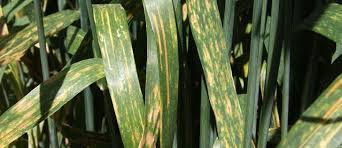

Train image 2: ..\data\CDDM-images\images\Wheat,LeafRust\plant_134029.jpg


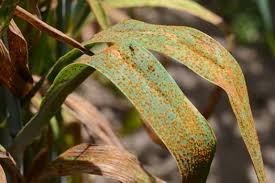

Train image 3: ..\data\CDDM-images\images\Wheat,LeafRust\plant_133217.jpg


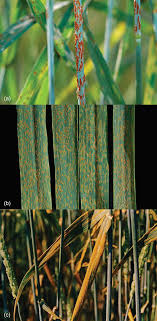

Train image 4: ..\data\CDDM-images\images\Wheat,LeafRust\plant_133793.jpg


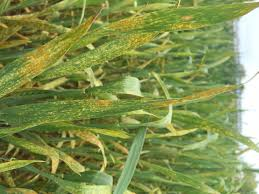

Train image 5: ..\data\CDDM-images\images\Wheat,LeafRust\plant_132737.jpg


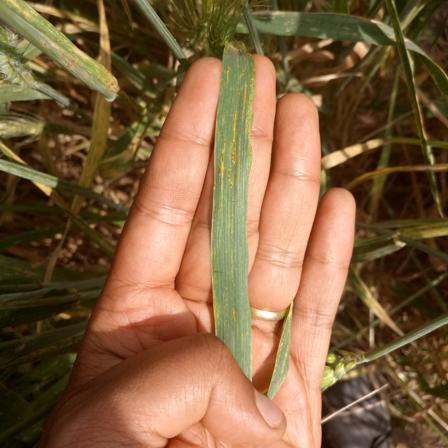

In [14]:
# Paths
base_image_dir = Path("../data/CDDM-images/images")
filtered_json_file = Path("filtered_wheat_dataset.json")

# Load filtered dataset
with open(filtered_json_file, "r", encoding="utf-8") as f:
    dataset = json.load(f)
train_data = dataset["train"]

# Display training images
print("Training images:")
for i, entry in enumerate(train_data):
    img_path = entry["image"]
    if img_path.startswith("images/") and str(base_image_dir).endswith("images"):
        rel_path = img_path[len("images/"):]
    else:
        rel_path = img_path
    full_path = base_image_dir / rel_path
    
    try:
        # Load image
        image = Image.open(full_path).convert("RGB")
        print(f"Train image {i+1}: {full_path}")
        # Display image
        display(image)
    except Exception as e:
        print(f"Error loading image {full_path}: {e}")

In [15]:
# VQA function
def vqa_inference_multi_turn(image_path, questions, model, processor, device, max_new_tokens=50):
    try:
        image = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

    conversation = []
    responses = []

    for i, question in enumerate(questions):
        if i == 0:
            conversation.append({
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": question}
                ]
            })
        else:
            conversation.append({
                "role": "user",
                "content": [
                    {"type": "text", "text": question}
                ]
            })

        try:
            text = processor.apply_chat_template(conversation, tokenize=False)
            inputs = processor(text=text, images=[image], return_tensors="pt").to(device)
        except Exception as e:
            print(f"Error processing conversation at turn {i+1} for {image_path}: {e}")
            return None

        try:
            with torch.no_grad():
                output_ids = model.generate(**inputs, max_new_tokens=max_new_tokens,pad_token_id=processor.tokenizer.eos_token_id)
            response = processor.decode(output_ids[0], skip_special_tokens=True)
            response = response.split(conversation[-1]["content"][-1]["text"])[-1].strip()
        except Exception as e:
            print(f"Error generating response at turn {i+1} for {image_path}: {e}")
            return None

        conversation.append({
            "role": "assistant",
            "content": [
                {"type": "text", "text": response}
            ]
        })
        responses.append(response)

    torch.cuda.empty_cache()
    return responses

# Paths
base_image_dir = Path("../data/CDDM-images/images")
filtered_json_file = Path("filtered_wheat_dataset.json")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load filtered dataset
with open(filtered_json_file, "r", encoding="utf-8") as f:
    dataset = json.load(f)
train_data = dataset["train"]

Base Model VQA Results:

Train image 1: ..\data\CDDM-images\images\Wheat,LeafRust\plant_133813.jpg


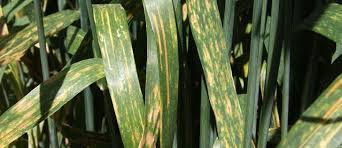

Ground truth - Plant: wheat leaf, Disease: Leaf Rust
Q: What plant does this leaf belong to?
A: system
The leaf in the picture appears to be from a wheat plant. Wheat leaves are known for their distinctive, elongated, and often striped or variegated appearance. The specific type of wheat leaf you are referring to might be a variety
Q: What disease does this leaf have?
A: assistant
The leaf in the picture does not appear to have any visible signs of disease. Wheat leaves can be affected by various diseases, such as leaf blight, rust, and powdery mildew, but these symptoms are not present in

Train image 2: ..\data\CDDM-images\images\Wheat,LeafRust\plant_134029.jpg


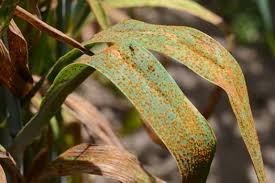

Ground truth - Plant: wheat leaf, Disease: Leaf Rust
Q: What plant does this leaf belong to?
A: system
The leaf in the picture appears to be from a corn plant. Corn leaves often show signs of rust disease, which can cause the leaves to turn brown and become covered with a reddish or orange-brown discoloration. Rust is
Q: What disease does this leaf have?
A: assistant
The leaf in the picture has rust disease. Rust is a type of fungal infection that can affect various plant species, including corn. It typically causes the leaves to turn brown and become covered with a reddish or orange-brown discolor

Train image 3: ..\data\CDDM-images\images\Wheat,LeafRust\plant_133217.jpg


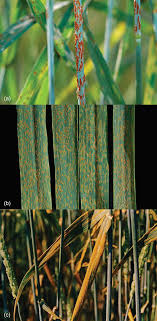

Ground truth - Plant: Unknown, Disease: Unknown
Q: What plant does this leaf belong to?
A: system
The leaf in the image belongs to a rice plant. The characteristic pattern of the leaf, with its elongated, narrow leaves and the distinct, zigzagging lines, is typical of rice plants.
Q: What disease does this leaf have?
A: assistant
The leaf in the image appears to have a disease called "Brown spot." This disease is characterized by the development of brown spots on the leaves, which can lead to the death of the plant if left untreated.

Train image 4: ..\data\CDDM-images\images\Wheat,LeafRust\plant_133793.jpg


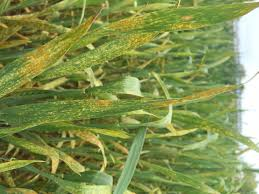

Ground truth - Plant: wheat leaf, Disease: Leaf Rust
Q: What plant does this leaf belong to?
A: system
The leaf in the picture appears to be from a corn plant. Corn leaves typically have a distinctive appearance with a central leaf vein and a series of smaller veins radiating outwards. The yellowish spots on the leaves are characteristic of corn
Q: What disease does this leaf have?
A: assistant
The leaf in the picture has a yellow spot, which is a common symptom of several diseases in corn. Some of the most common diseases that can cause yellow spots in corn include:

  * Bacterial leaf blight
  * B

Train image 5: ..\data\CDDM-images\images\Wheat,LeafRust\plant_132737.jpg


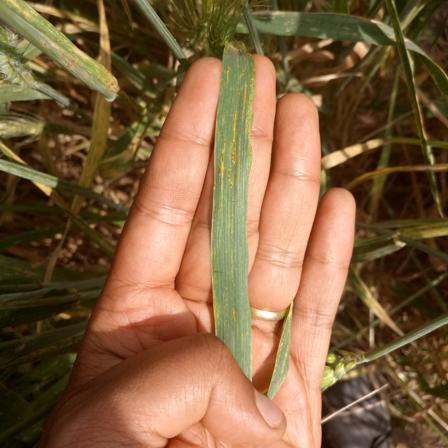

Ground truth - Plant: wheat leaf, Disease: Leaf Rust
Q: What plant does this leaf belong to?
A: user
(470,101),(602,887)What is the plant in the picture?
Q: What disease does this leaf have?
A: assistant
The leaf in the picture appears to have a yellowing or discoloration, which could be indicative of a number of plant diseases. Some common diseases that can cause yellowing in plants include bacterial leaf blight, fungal leaf blight


In [14]:
# # Load base model and processor
# processor = AutoProcessor.from_pretrained("../models/qwen2_vl_2b_instruct")
# base_model = Qwen2VLForConditionalGeneration.from_pretrained(
#     "../models/qwen2_vl_2b_instruct",
#     torch_dtype=torch.float16,
#     device_map=device
# )
# base_model.eval()


# # Questions
# questions = [
#     "What plant does this leaf belong to?",
#     "What disease does this leaf have?"
# ]

# # Display images and perform VQA
# print("Base Model VQA Results:")
# for i, entry in enumerate(train_data):
#     img_path = entry["image"]
#     if img_path.startswith("images/") and str(base_image_dir).endswith("images"):
#         rel_path = img_path[len("images/"):]
#     else:
#         rel_path = img_path
#     full_path = base_image_dir / rel_path
    
#     # Display image
#     try:
#         image = Image.open(full_path).convert("RGB")
#         print(f"\nTrain image {i+1}: {full_path}")
#         display(image)
#     except Exception as e:
#         print(f"Error loading image {full_path}: {e}")
#         continue
    
#     # Get ground truth
#     conv = entry["conversations"]
#     ground_truth = {"plant": "Unknown", "disease": "Unknown"}
#     for j in range(len(conv) - 1):
#         if conv[j]["from"] == "human":
#             if "What plant" in conv[j]["value"] or "leaf is this" in conv[j]["value"]:
#                 ground_truth["plant"] = conv[j + 1]["value"].replace("This is a ", "").rstrip(".")
#             if "What disease does this wheat leaf have" in conv[j]["value"]:
#                 ground_truth["disease"] = conv[j + 1]["value"].replace("This wheat leaf is affected by ", "").rstrip(".")
    
#     # Perform VQA
#     responses = vqa_inference_multi_turn(full_path, questions, base_model, processor, device)
#     print(f"Ground truth - Plant: {ground_truth['plant']}, Disease: {ground_truth['disease']}")
#     if responses:
#         for q, r in zip(questions, responses):
#             print(f"Q: {q}")
#             print(f"A: {r}")
#     else:
#         print("VQA failed for this image.")

In [15]:
torch.cuda.empty_cache()

In [16]:
questions = [
    "What plant does this leaf belong to?",
    "What disease does this leaf have?"
]

Fine-Tuned Model VQA Results:

Train image 1: ..\data\CDDM-images\images\Wheat,LeafRust\plant_133813.jpg


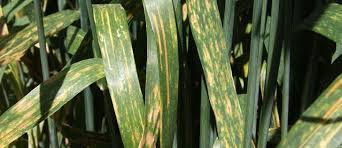

Ground truth - Plant: wheat leaf, Disease: Leaf Rust
Q: What plant does this leaf belong to?
A: system
The leaf in the picture appears to be from a wheat plant. Wheat leaves are known for their distinctive, elongated, and often striped or variegated appearance. The specific type of wheat leaf you are referring to might be a variety
Q: What disease does this leaf have?
A: assistant
The leaf in the picture does not appear to have any visible signs of disease. Wheat leaves can be affected by various diseases, such as leaf blight, rust, and powdery mildew, but these symptoms are not present in

Train image 2: ..\data\CDDM-images\images\Wheat,LeafRust\plant_134029.jpg


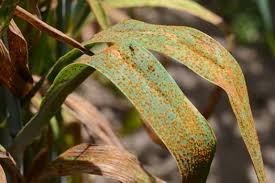

Ground truth - Plant: wheat leaf, Disease: Leaf Rust
Q: What plant does this leaf belong to?
A: system
The leaf in the picture appears to be from a corn plant. Corn leaves often show signs of rust disease, which can cause the leaves to turn brown and become covered with a reddish or orange-brown discoloration. Rust is
Q: What disease does this leaf have?
A: assistant
The leaf in the picture has rust disease. Rust is a type of fungal infection that can affect various plant species, including corn. It typically causes the leaves to turn brown and become covered with a reddish or orange-brown discolor

Train image 3: ..\data\CDDM-images\images\Wheat,LeafRust\plant_133217.jpg


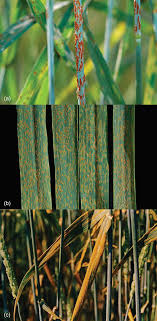

Ground truth - Plant: Unknown, Disease: Unknown
Q: What plant does this leaf belong to?
A: system
The leaf in the image belongs to a rice plant. The characteristic pattern of the leaf, with its elongated, narrow leaves and the distinctive yellowish-brown spots, is typical of rice plants.
Q: What disease does this leaf have?
A: assistant
The leaf in the image has a disease called "Brown spot." This disease is characterized by the development of brown spots on the leaves, which can lead to the death of the plant if left untreated.

Train image 4: ..\data\CDDM-images\images\Wheat,LeafRust\plant_133793.jpg


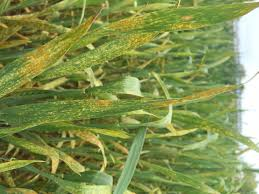

Ground truth - Plant: wheat leaf, Disease: Leaf Rust
Q: What plant does this leaf belong to?
A: system
The leaf in the picture appears to be from a corn plant. Corn leaves typically have a distinctive appearance with a central leaf vein and a series of smaller veins radiating outwards. The yellowish spots on the leaves are characteristic of corn
Q: What disease does this leaf have?
A: assistant
The leaf in the picture has a yellow spot, which is a common symptom of several diseases in corn. Some of the most common diseases that can cause yellow spots in corn include:

  * Bacterial leaf blight
  * B

Train image 5: ..\data\CDDM-images\images\Wheat,LeafRust\plant_132737.jpg


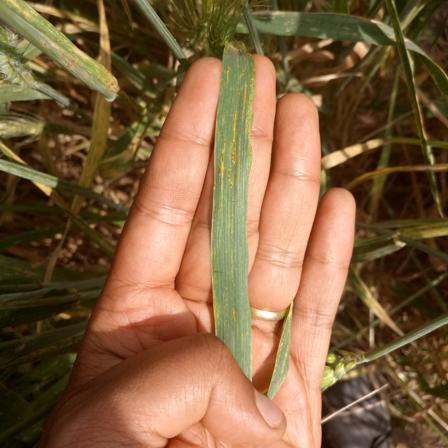

Ground truth - Plant: wheat leaf, Disease: Leaf Rust
Q: What plant does this leaf belong to?
A: user
(470,101),(602,889)What is the plant in the picture?
Q: What disease does this leaf have?
A: assistant
The leaf in the picture appears to have a yellowing or discoloration, which could be indicative of a number of plant diseases. Some common diseases that can cause yellowing in plants include bacterial leaf blight, fungal leaf blight


In [17]:
# Load fine-tuned model and processor
processor = AutoProcessor.from_pretrained("../models/qwen2_vl_2b_instruct")
finetuned_model = Qwen2VLForConditionalGeneration.from_pretrained(
    "../models/qwen2_vl_2b_instruct",
    torch_dtype=torch.float16,
    device_map=device
)
finetuned_model = PeftModel.from_pretrained(finetuned_model, "./qwen2vl_lora_finetuned/adapters")
finetuned_model.eval()

# Display images and perform VQA
print("Fine-Tuned Model VQA Results:")
for i, entry in enumerate(train_data):
    img_path = entry["image"]
    if img_path.startswith("images/") and str(base_image_dir).endswith("images"):
        rel_path = img_path[len("images/"):]
    else:
        rel_path = img_path
    full_path = base_image_dir / rel_path
    
    # Display image
    try:
        image = Image.open(full_path).convert("RGB")
        print(f"\nTrain image {i+1}: {full_path}")
        display(image)
    except Exception as e:
        print(f"Error loading image {full_path}: {e}")
        continue
    
    # Get ground truth
    conv = entry["conversations"]
    ground_truth = {"plant": "Unknown", "disease": "Unknown"}
    for j in range(len(conv) - 1):
        if conv[j]["from"] == "human":
            if "What plant" in conv[j]["value"] or "leaf is this" in conv[j]["value"]:
                ground_truth["plant"] = conv[j + 1]["value"].replace("This is a ", "").rstrip(".")
            if "What disease does this wheat leaf have" in conv[j]["value"]:
                ground_truth["disease"] = conv[j + 1]["value"].replace("This wheat leaf is affected by ", "").rstrip(".")
    
    # Perform VQA
    responses = vqa_inference_multi_turn(full_path, questions, finetuned_model, processor, device)
    print(f"Ground truth - Plant: {ground_truth['plant']}, Disease: {ground_truth['disease']}")
    if responses:
        for q, r in zip(questions, responses):
            print(f"Q: {q}")
            print(f"A: {r}")
    else:
        print("VQA failed for this image.")

In [15]:
# Load processor
processor = AutoProcessor.from_pretrained("../models/qwen2_vl_2b_instruct")
processor.tokenizer.pad_token_id = processor.tokenizer.eos_token_id

# Define WheatDataset (same as used during training)
class WheatDataset(Dataset):
    def __init__(self, data, base_image_dir, processor, max_len):
        self.data = data
        self.base_dir = Path(base_image_dir)
        self.processor = processor
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        img_path = entry["image"]
        if img_path.startswith("images/") and str(self.base_dir).endswith("images"):
            rel_path = img_path[len("images/"):]
        else:
            rel_path = img_path
        full_path = self.base_dir / rel_path

        image = Image.open(full_path).convert("RGB")

        conv = entry["conversations"]
        for i in range(len(conv) - 1):
            if conv[i]["from"] == "human" and "What disease does this wheat leaf have?" in conv[i]["value"]:
                disease = conv[i + 1]["value"].replace("This wheat leaf is affected by ", "").rstrip(".")
                break
        else:
            disease = "Unknown"

        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": "What disease does this wheat leaf have?"}
                ]
            },
            {
                "role": "assistant",
                "content": [{"type": "text", "text": disease}]
            }
        ]

        text = self.processor.apply_chat_template(messages, tokenize=False)

        inputs = self.processor(
            text=text,
            images=[image],
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs["labels"] = inputs["input_ids"].clone()

        return inputs

# Define VQA Inference Function
def vqa_inference(image_path, question, model, processor, device):
    image = Image.open(image_path).convert("RGB")
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": question}
            ]
        }
    ]
    # Apply chat template without system prompt
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(
        text=text,
        images=[image],
        return_tensors="pt"
    ).to(device)

    # Ensure pad_token_id is set in the model config
    if model.config.pad_token_id is None:
        model.config.pad_token_id = processor.tokenizer.pad_token_id

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=50,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            pad_token_id=processor.tokenizer.pad_token_id  # Explicitly pass pad_token_id
        )
    # Decode only the generated part, skipping special tokens and conversational artifacts
    response = processor.decode(outputs[0], skip_special_tokens=True)
    # Remove any conversational artifacts (e.g., "system", "user") by taking the last part after the last "system"
    if "system" in response:
        response = response.split("system")[-1].strip()
    return response

# Reload and split data to recreate train_data
json_file = Path("wheat_dataset.json")
with open(json_file, "r", encoding="utf-8") as f:
    all_data = json.load(f)

# Limit to 5 samples and split 3/1/1 (train/val/test)
if len(all_data) > 5:
    all_data = all_data[:5]
train_data, temp_data = train_test_split(all_data, train_size=3, test_size=2, random_state=42)
val_data, test_data = train_test_split(temp_data, train_size=1, test_size=1, random_state=42)

# Define base_image_dir
base_image_dir = Path("../data/CDDM-images/images")

# Recreate make_supervised_data_module to generate train_dataset
class DataArgs:
    def __init__(self, data_path, lazy_preprocess):
        self.data_path = data_path
        self.lazy_preprocess = lazy_preprocess

def make_supervised_data_module(tokenizer, data_args, max_len):
    train_dataset = WheatDataset(
        data=train_data,  # Use the pre-split train_data (same 3 images)
        base_image_dir="../data/CDDM-images/images",
        processor=processor,
        max_len=max_len
    )
    
    def data_collator(features):
        batch = {}
        for key in features[0].keys():
            batch[key] = torch.stack([f[key] for f in features])
        return batch

    return {
        "train_dataset": train_dataset,
        "eval_dataset": None,
        "data_collator": data_collator
    }

# Define data_args
data_args = DataArgs(
    data_path="wheat_dataset.json",
    lazy_preprocess=True
)

# Create data module to get train_dataset
data_module = make_supervised_data_module(
    tokenizer=processor.tokenizer,
    data_args=data_args,
    max_len=2048
)

# Extract train_dataset
train_dataset = data_module["train_dataset"]
print(f"Train dataset size: {len(train_dataset)}")

Train dataset size: 3


Displaying the 3 Fine-Tuned Images Before Evaluation:
Train image 1: ..\data\CDDM-images\images\Wheat,LeafRust\plant_134217.jpg


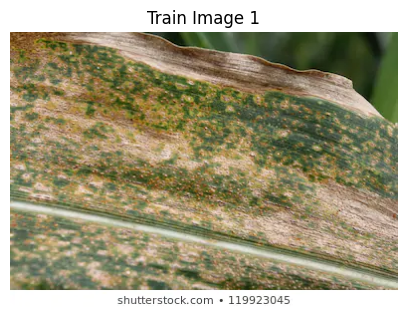

Train image 2: ..\data\CDDM-images\images\Wheat,LeafRust\plant_133831.jpg


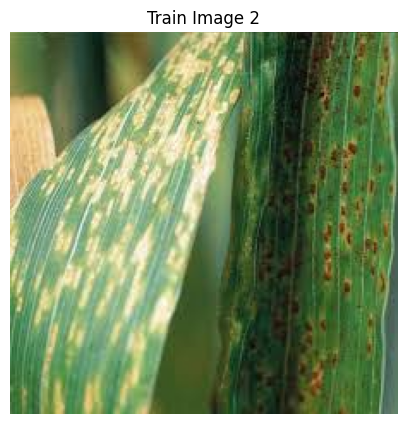

Train image 3: ..\data\CDDM-images\images\Wheat,RootRot\plant_130430.jpg


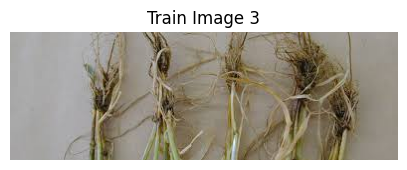

In [16]:
print("Displaying the 3 Fine-Tuned Images Before Evaluation:")
for idx, entry in enumerate(train_data):
    img_path = entry["image"]
    if img_path.startswith("images/") and str(base_image_dir).endswith("images"):
        rel_path = img_path[len("images/"):]
    else:
        rel_path = img_path
    image_path = base_image_dir / rel_path
    print(f"Train image {idx + 1}: {image_path}")

    # Load and display the image
    image = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis("off")  # Hide axes
    plt.title(f"Train Image {idx + 1}")
    plt.show()

In [17]:
# Evaluate Base Model on the Training Dataset (same 3 images used for fine-tuning)
base_model = Qwen2VLForConditionalGeneration.from_pretrained(
    "../models/qwen2_vl_2b_instruct",
    torch_dtype=torch.float16,
    device_map="auto"
)
base_model.to(device)

print("\nBase Model VQA Results on Training Dataset (3 Fine-Tuned Images):")
for idx, entry in enumerate(train_data):
    img_path = entry["image"]
    # Strip 'images/' prefix if base_image_dir already ends with 'images'
    if img_path.startswith("images/") and str(base_image_dir).endswith("images"):
        rel_path = img_path[len("images/"):]
    else:
        rel_path = img_path
    image_path = base_image_dir / rel_path
    print(f"Train image {idx + 1}: {image_path}")

    # Inference: Plant
    question_plant = "What plant does this leaf belong to?"
    response_plant = vqa_inference(image_path, question_plant, base_model, processor, device)
    print(f"Q: {question_plant}")
    print(f"A: {response_plant}")

    # Inference: Disease
    question_disease = "What disease does this wheat leaf have?"
    response_disease = vqa_inference(image_path, question_disease, base_model, processor, device)
    print(f"Q: {question_disease}")
    print(f"A: {response_disease}\n")

# Clear base model from memory
del base_model
torch.cuda.empty_cache()
print("Base model cleared from memory.")

c:\Users\Mir Ali\AppData\Local\Programs\Python\Python312\Lib\site-packages\accelerate\utils\modeling.py:1569: UserWarning: Current model requires 3752 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(



Base Model VQA Results on Training Dataset (3 Fine-Tuned Images):
Train image 1: ..\data\CDDM-images\images\Wheat,LeafRust\plant_134217.jpg
Q: What plant does this leaf belong to?
A: You are a helpful assistant.
user
What plant does this leaf belong to?
assistant
The leaf in the image appears to be from a plant that is susceptible to certain diseases and pests, including leaf blight. Leaf blight can be caused by fungi such as Pythium, Rhizoctonia, or Sclerotinia.
Q: What disease does this wheat leaf have?
A: You are a helpful assistant.
user
What disease does this wheat leaf have?
assistant
The wheat leaf in the picture appears to have a variety of diseases, including:

1. **Brown spot**: This is a common fungal disease that causes the leaves to turn brown and dry. It is caused by fungi such as Pythium and Per

Train image 2: ..\data\CDDM-images\images\Wheat,LeafRust\plant_133831.jpg
Q: What plant does this leaf belong to?
A: You are a helpful assistant.
user
What plant does this leaf

In [8]:
# Evaluate Fine-Tuned Model on the Training Dataset (same 3 images used for fine-tuning)
finetuned_model = Qwen2VLForConditionalGeneration.from_pretrained(
    "../models/qwen2_vl_2b_instruct",
    torch_dtype=torch.float16,
    device_map="auto"
)
finetuned_model.load_adapter("./qwen2vl_lora_finetuned/adapters")
finetuned_model.to(device)

print("\nFine-Tuned Model VQA Results on Training Dataset (3 Fine-Tuned Images):")
for idx, entry in enumerate(train_data):
    img_path = entry["image"]
    # Strip 'images/' prefix if base_image_dir already ends with 'images'
    if img_path.startswith("images/") and str(base_image_dir).endswith("images"):
        rel_path = img_path[len("images/"):]
    else:
        rel_path = img_path
    image_path = base_image_dir / rel_path
    print(f"Train image {idx + 1}: {image_path}")

    # Inference: Plant
    question_plant = "What plant does this leaf belong to?"
    response_plant = vqa_inference(image_path, question_plant, finetuned_model, processor, device)
    print(f"Q: {question_plant}")
    print(f"A: {response_plant}")

    # Inference: Disease
    question_disease = "What disease does this wheat leaf have?"
    response_disease = vqa_inference(image_path, question_disease, finetuned_model, processor, device)
    print(f"Q: {question_disease}")
    print(f"A: {response_disease}\n")

# Clear fine-tuned model from memory
del finetuned_model
torch.cuda.empty_cache()
print("Fine-tuned model cleared from memory.")

c:\Users\Mir Ali\AppData\Local\Programs\Python\Python312\Lib\site-packages\accelerate\utils\modeling.py:1569: UserWarning: Current model requires 7504 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.



Fine-Tuned Model VQA Results on Training Dataset (3 Fine-Tuned Images):
Train image 1: ..\data\CDDM-images\images\Wheat,LeafRust\plant_134217.jpg


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Q: What plant does this leaf belong to?
A: system
You are a helpful assistant.
user
What plant does this leaf belong to?
system
The leaf in the image appears to belong to a corn plant. The characteristic pattern of browning and yellowing with green patches and brown speckles is commonly associated with the corn leaf blight, which is a fungal disease caused by


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Q: What disease does this wheat leaf have?
A: system
You are a helpful assistant.
user
What disease does this wheat leaf have?
system
The wheat leaf in the picture appears to be affected by a fungal disease known as head smut. Head smut is caused by a fungus that infects the head of wheat plants, causing the head to turn brown and dry out.

Train image 2: ..\data\CDDM-images\images\Wheat,LeafRust\plant_133831.jpg


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Q: What plant does this leaf belong to?
A: system
You are a helpful assistant.
user
What plant does this leaf belong to?
system
The leaf with the visible spots on it is likely to belong to a corn plant. Corn leaves typically have green, yellow, or white spots due to the presence of a disease called corn leaf spot. This is a common pest and disease


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Q: What disease does this wheat leaf have?
A: system
You are a helpful assistant.
user
What disease does this wheat leaf have?
system
The leaf in the picture appears to have signs of a fungal infection known as wheat rust. Wheat rust is caused by the fungus Puccinia graminis, which is a major pest of wheat. The rust is spread by wind,

Train image 3: ..\data\CDDM-images\images\Wheat,RootRot\plant_130430.jpg


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Q: What plant does this leaf belong to?
A: system
You are a helpful assistant.
user
What plant does this leaf belong to?
user
This image has several plants with dried up leaves and stems. The dried up leaves and stems could indicate a plant that is experiencing a drought. It is also possible that the plant is experiencing other stressors such as disease or pest damage.
Q: What disease does this wheat leaf have?
A: system
You are a helpful assistant.
user
What disease does this wheat leaf have?
system
The disease in the picture is likely to be stem rust (Puccinia graminis f. sp. tritici). This disease affects many crop plants, including wheat, and can cause the leaves to turn brown and wilting

Fine-tuned model cleared from memory.
